In [56]:
import numpy as np

from numba import njit
from numpy import log, sqrt
from scipy.optimize import root_scalar
from scipy.stats import chi2

@njit('float64(float64, float64, float64, float64, float64)')
def wstat(rate_src, n_on, n_off, t_on, t_off):
    mu_src = rate_src * t_on
    a = t_on / t_off
    v1 = a + 1.0      # a + 1
    v2 = 1.0 + 1.0/a  # 1 + 1/a
    v3 = 2.0 * v1     # 2*(a+1)
    v4 = 4 * a * v1   # 4*a*(a+1)

    on = n_on
    off = n_off
    s = mu_src

    if on == 0.0:
        stat = s + off*log(v1)
    else:
        if off == 0.0:
            if s <= on / v2:
                stat = -s/a + on*log(v2)
            else:
                stat = s + on*(log(on/s) - 1.0)
        else:
            c = a * (on + off) - v1 * s
            d = sqrt(c*c + v4 * off * s)
            b = (c + d) / v3
            stat = s + v2 * b \
                    - on * (log((s + b)/on) + 1) \
                    - off * (log(b/a/off) + 1)
    return stat

def wstat_ci(n_on, n_off, t_on, t_off, cl=0.68269):
    delta = chi2.ppf(cl, 1) / 2.0
    rate_on = n_on/t_on
    rate_off = n_off/t_off
    if (s := rate_on - rate_off) < 0.0:
        s = 0.0
    stat_min = wstat(s, n_on, n_off, t_on, t_off)
    f = lambda x: wstat(x, n_on, n_off, t_on, t_off) - (stat_min + delta)
    if (lower := root_scalar(f, bracket=(-rate_off, s)).root) < 0.0:
        lower = 0.0
    upper = root_scalar(f, bracket=(s, max(rate_on, rate_off))).root
    return s, (lower, upper)

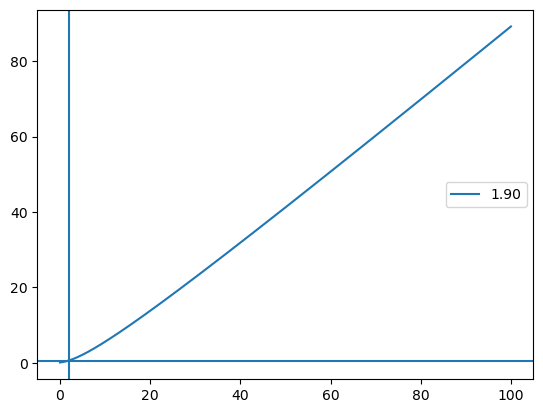

In [90]:
# profile likelihood
src = np.linspace(0,1e2,1001)
stat = np.asarray([wstat(s, 3, 4, 1, 1) for s in src])
import matplotlib.pyplot as plt
plt.plot(src, stat)
plt.axhline(stat.min()+0.5)
plt.axvline(_:=src[stat.argmin():][np.abs(stat[stat.argmin():]-stat.min()-0.5).argmin()], label=f'{_:.2f}')
# plt.axvline(_:=src[:stat.argmin()][np.abs(stat[:stat.argmin()]-stat.min()-0.5).argmin()], label=f'{_:.2f}')
plt.legend()

In [47]:
from scipy.stats import chi2, norm
chi2.ppf(1-norm.sf(1)*2, 1)/2, chi2.ppf(0.9, 1)/2, chi2.ppf(0.95, 1)/2

(0.49999999999999967, 1.352771727047702, 1.920729410347062)

1.0006418287624492